In [1]:
import os
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import train_test_split , cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
import multiprocessing
import matplotlib.pyplot as plt

data process(Binary)

In [40]:
class data_proc():
    
    def process_zip():
        #dealing with zipcode
        zip_data=pd.read_csv('ZIP.csv')
        zip_data['Zip']=zip_data['Zip'].astype(str)
        for i in range(len(zip_data['Zip'])):
            if len(zip_data['Zip'][i])==4:
                zip_data['Zip'][i]='0'+zip_data['Zip'][i]
        zip_data['Zip']=[zip_data['Zip'][i][0:3] for i in range(len(zip_data))] 
        zip_data.iloc[:,-3:]=zip_data[['Median','Mean','Pop']].apply(lambda x: x.str.replace(',',''))
        for i in range(1,4):
            zip_data.iloc[:,-i]=pd.to_numeric(zip_data.iloc[:,-i],errors='coerce')
        zip_data['weight']=zip_data['Pop']/zip_data.groupby('Zip')['Pop'].transform(sum)
        zip_data['new_mean']=zip_data['Mean']*zip_data['weight']
        zip_data['new_median']=zip_data['Median']*zip_data['weight']
        zip_new=pd.DataFrame()
        zip_new=zip_data.groupby('Zip')['new_mean','new_median'].sum()
        return zip_new
        
    def readcsv():
        LARGE_FILE = "loan_data_no_current_converted.csv"
        CHUNKSIZE = 100000 # processing 100,000 rows at a time
        reader = pd.read_csv(LARGE_FILE, chunksize=CHUNKSIZE, low_memory=False)
        frames = []
        for df in reader:
            frames.append(df)
        loan_data = pd.concat(frames)
        return loan_data   
    def cleaning(df,zip_new,keep_desc=True,categorical_to_binary=True):
        #find the drop_list in kaggle
        whole_list=[]
        for key, value in df.iteritems():
            whole_list.append(key)
        #kaggle features
        keep_list=[ 'loan_amnt', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan',  
                    'purpose','zip_code', 'dti', 'delinq_2yrs','inq_last_6mths', 'mths_since_last_delinq', 
                    'mths_since_last_record', 'open_acc','pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'total_pymnt',
                    'total_rec_prncp','total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
                    'last_pymnt_amnt', 'next_pymnt_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 
                    'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 
                    'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 
                    'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 
                    'total_cu_tl', 'inq_last_12m']
        drop_list=[]
        for key in whole_list:
            if key not in keep_list:
                drop_list.append(key)
        #drop features not in kaggle
        df.drop(drop_list,inplace=True,axis=1,errors='ignore')
        #deal with percentage mark
        df['revol_util']=df['revol_util'].replace('%','',regex=True).astype('float')/100
        #merge zipcode with census data
        df['zip_code']=df['zip_code'].apply(lambda x: x[:3])
        df=df.join(zip_new,on='zip_code')
        df.drop('zip_code',inplace=True,axis=1)
        #drop the observation that was missing for ALL field
        df=df.dropna(axis=0,how='all')
        #drop the features for which greater than 10% of the loans were missing data for
        num_rows=df.count(axis=0)
        df=df.iloc[:,(num_rows>=0.9*len(df)).tolist()]
        #drop the observation that was missing for any field
        df=df.dropna(axis=0,how='any')
        #label the dataset to create y
        y=df['loan_status'].replace(8,0)
        y=y.replace(1,1)
        y=y.replace(2,1)
        y=y.replace(3,0)
        y=y.replace(4,0)
        y=y.replace(5,0)
        y=y.replace(6,0)
        y=y.replace(7,0)
        df=df.drop(['loan_status'],axis=1)    
        return df,y

data process(Multi-Class)

In [64]:
class Multi_data_proc():
    
    def process_zip():
        #dealing with zipcode
        zip_data=pd.read_csv('ZIP.csv')
        zip_data['Zip']=zip_data['Zip'].astype(str)
        for i in range(len(zip_data['Zip'])):
            if len(zip_data['Zip'][i])==4:
                zip_data['Zip'][i]='0'+zip_data['Zip'][i]
        zip_data['Zip']=[zip_data['Zip'][i][0:3] for i in range(len(zip_data))] 
        zip_data.iloc[:,-3:]=zip_data[['Median','Mean','Pop']].apply(lambda x: x.str.replace(',',''))
        for i in range(1,4):
            zip_data.iloc[:,-i]=pd.to_numeric(zip_data.iloc[:,-i],errors='coerce')
        zip_data['weight']=zip_data['Pop']/zip_data.groupby('Zip')['Pop'].transform(sum)
        zip_data['new_mean']=zip_data['Mean']*zip_data['weight']
        zip_data['new_median']=zip_data['Median']*zip_data['weight']
        zip_new=pd.DataFrame()
        zip_new=zip_data.groupby('Zip')['new_mean','new_median'].sum()
        return zip_new
        
    def readcsv():
        LARGE_FILE = "loan_data_no_current_converted.csv"
        CHUNKSIZE = 100000 # processing 100,000 rows at a time
        reader = pd.read_csv(LARGE_FILE, chunksize=CHUNKSIZE, low_memory=False)
        frames = []
        for df in reader:
            frames.append(df)
        loan_data = pd.concat(frames)
        return loan_data   
    def cleaning(df,zip_new,keep_desc=True,categorical_to_binary=True):
        #find the drop_list in kaggle
        whole_list=[]
        for key, value in df.iteritems():
            whole_list.append(key)
        #kaggle features
        keep_list=[ 'loan_amnt', 'emp_length', 'home_ownership', 'annual_inc', 'verification_status', 'loan_status', 'pymnt_plan',  
                    'purpose','zip_code', 'dti', 'delinq_2yrs','inq_last_6mths', 'mths_since_last_delinq', 
                    'mths_since_last_record', 'open_acc','pub_rec', 'revol_bal', 'revol_util', 'total_acc', 'initial_list_status', 'total_pymnt',
                    'total_rec_prncp','total_rec_int', 'total_rec_late_fee', 'recoveries', 'collection_recovery_fee', 
                    'last_pymnt_amnt', 'next_pymnt_d', 'collections_12_mths_ex_med', 'mths_since_last_major_derog', 
                    'policy_code', 'application_type', 'annual_inc_joint', 'dti_joint', 'verification_status_joint', 'acc_now_delinq', 
                    'tot_coll_amt', 'tot_cur_bal', 'open_acc_6m', 'open_il_6m', 'open_il_12m', 'open_il_24m', 'mths_since_rcnt_il', 
                    'total_bal_il', 'il_util', 'open_rv_12m', 'open_rv_24m', 'max_bal_bc', 'all_util', 'total_rev_hi_lim', 'inq_fi', 
                    'total_cu_tl', 'inq_last_12m']
        drop_list=[]
        for key in whole_list:
            if key not in keep_list:
                drop_list.append(key)
        #drop features not in kaggle
        df.drop(drop_list,inplace=True,axis=1,errors='ignore')
        #deal with percentage mark
        df['revol_util']=df['revol_util'].replace('%','',regex=True).astype('float')/100
        #merge zipcode with census data
        df['zip_code']=df['zip_code'].apply(lambda x: x[:3])
        df=df.join(zip_new,on='zip_code')
        df.drop('zip_code',inplace=True,axis=1)
        #drop the observation that was missing for ALL field
        df=df.dropna(axis=0,how='all')
        #drop the features for which greater than 10% of the loans were missing data for
        num_rows=df.count(axis=0)
        df=df.iloc[:,(num_rows>=0.9*len(df)).tolist()]
        #drop the observation that was missing for any field
        df=df.dropna(axis=0,how='any')
        #label the dataset to create y
        #0:fully paid, does not meet policy:fully paid
        #1: Grace period
        #2:Late(16-30days),Late(31-120 days)
        #3:"Does not meet the credit policy. Status:Charged Off",default,charge of
        y=df['loan_status'].replace(1,0)
        y=y.replace(2,0)
        y=y.replace(5,2)
        y=y.replace(6,2)
        y=y.replace(4,1)
        y=y.replace(3,3)
        y=y.replace(7,3)
        y=y.replace(8,3)
        df=df.drop(['loan_status'],axis=1)    
        return df,y

Run data_proc class to get Binary dataset

In [77]:
zipdata = data_proc.process_zip()
df = data_proc.readcsv()
x,y = data_proc.cleaning(df,zipdata,keep_desc=False,categorical_to_binary=True)

features in dataset

In [43]:
for key, value in x.iteritems():
    print(key)

loan_amnt
emp_length
home_ownership
annual_inc
verification_status
pymnt_plan
purpose
dti
delinq_2yrs
inq_last_6mths
open_acc
pub_rec
revol_bal
revol_util
total_acc
initial_list_status
total_pymnt
total_rec_prncp
total_rec_int
total_rec_late_fee
recoveries
collection_recovery_fee
last_pymnt_amnt
collections_12_mths_ex_med
policy_code
application_type
acc_now_delinq
tot_coll_amt
tot_cur_bal
total_rev_hi_lim
new_mean
new_median


Run Mutli-class process to get multi-class dataset

In [47]:
x_multi,y_multi = Multi_data_proc.cleaning(df,zipdata,keep_desc=False,categorical_to_binary=True)

Binary Logistic Regression(Ridge) 

In [35]:
#%% Binary logistic regression
class log_reg():
    # Evaluate the model by splitting into train and test sets
    def split(x,y,rand=0):
        
        y = np.ravel(y)
        x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25,random_state=rand)
        
        return x_train, x_test, y_train, y_test 
    #we need to add validation dataset here
    
    # Find binary column method one
    def bool_cols(df,isbool=True):
        bool_cols=[]
        for col in df:
            if isbool==True:
                if df[col].dropna().value_counts().index.isin([0,1]).all():
                    bool_cols.append(col)
            else:
                if not df[col].dropna().value_counts().index.isin([0,1]).all():
                    bool_cols.append(col)
        return bool_cols
    # this above step is to facilitate normalization later
    # method two
    def not_bi(x):
        not_bi=[]
        for i in list(x):
            u=x[i].unique()
            if not (0 in u and 1 in u and len(u)==2): #if not binary
                not_bi.append(i)
        return not_bi
    
    def reg(x_train, y_train):
           
        model = LogisticRegression(penalty='l2',class_weight='balanced',solver='sag',n_jobs=-1)
        
        """
        Why we need standardize?
        
        Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features 
        with approximately the same scale. You can preprocess the data with 
        a scaler from sklearn.preprocessing.
        """
        
        model = model.fit(x_train, y_train)
        
        return model
    
    def ModelValuation(x_test,y_test,model):
        
        probs = model.predict_proba(x_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
        
        plt.figure(1)
        plt.plot(fpr, tpr, label='LogisticRegression')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
        
        print("Area Under the Curve (AUC) from prediction score is %f" % metrics.roc_auc_score(y_test, probs[:, 1]))
    
        return None  
    
    def y_pred(x_test,threshold=0.5):
        
        if threshold == 0.5:
            y_predicted = model.predict(x_test)
        else:
            probs = model.predict_proba(x_test)
            y_predicted = np.array(probs[:,1] >= threshold).astype(int)
        
        return y_predicted    
    
    def GetScores(y_test,y_predicted):
        #G means score 
        CM = metrics.confusion_matrix(y_test, y_predicted)
        TN = CM[0,0]
        FN = CM[1,0]
        TP = CM[1,1]
        FP = CM[0,1]
        
        sensitivity = float(TP)/float(TP+FN)
        specificity = float(TN)/float(TN+FP)
        G = np.sqrt(sensitivity*specificity)
        print("G score is %f" % G)
        print("Specificity is %f" % specificity)
        
        # Generate and display different evaluation metrics
        print("Mean accuracy score is %f" % metrics.accuracy_score(y_test, y_predicted))
          
        print("Confusion Marix")
        print(CM)
        
        return specificity , G
        
    # Convenience function to plot confusion matrix
    def confusion(y_test,y_predicted,title):
        
        # Define names for the three Iris types
        names = ['Default', 'Not Default']
    
        # Make a 2D histogram from the test and result arrays
        pts, xe, ye = np.histogram2d(y_test, y_predicted, bins=2)
    
        # For simplicity we create a new DataFrame
        pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
        
        # Display heatmap and add decorations
        hm = sns.heatmap(pd_pts, annot=True, fmt="d")
        hm.axes.set_title(title)
        
        return None
            
    def find_threshold(x_test,y_test):
    
        probs = model.predict_proba(x_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
        
        sensitivity = tpr
        specificity = 1 - fpr
        G = np.sqrt(sensitivity*specificity)
        
        plt.figure(2)
        plt.plot(thresholds,G)
        plt.xlabel('Thresholds')
        plt.ylabel('G-Scores')
        plt.title('G-Scores with different thresholds')
        plt.show()
        
        
        print("The highest G score is %f with threshold at %f" % (np.amax(G),thresholds[np.argmax(G)]) )
        
        return thresholds[np.argmax(G)]
    # this is just testing, we add weight so we don't need to adjust threshold

Multi-Class Logistic Regression(Ridge)

In [65]:
#%% logistic regression
class Multi_log_reg():
    # Evaluate the model by splitting into train and test sets
    def split(x,y,rand=0):
        
        y = np.ravel(y)
        x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25,random_state=rand)
        
        return x_train, x_test, y_train, y_test 
    #we need to add validation dataset here
    
    # Find binary column method one
    def bool_cols(df,isbool=True):
        bool_cols=[]
        for col in df:
            if isbool==True:
                if df[col].dropna().value_counts().index.isin([0,1]).all():
                    bool_cols.append(col)
            else:
                if not df[col].dropna().value_counts().index.isin([0,1]).all():
                    bool_cols.append(col)
        return bool_cols
    # this above step is to facilitate normalization later
    # method two
    def not_bi(x):
        not_bi=[]
        for i in list(x):
            u=x[i].unique()
            if not (0 in u and 1 in u and len(u)==2): #if not binary
                not_bi.append(i)
        return not_bi
    
    def reg(x_train, y_train):
           
        model = LogisticRegression(penalty='l2',class_weight='balanced',solver='sag',n_jobs=-1,multi_class='multinomial')
        
        """
        Why we need standardize?
        
        Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features 
        with approximately the same scale. You can preprocess the data with 
        a scaler from sklearn.preprocessing.
        """
        
        model = model.fit(x_train, y_train)
        
        return model
    
    def score(X,y,model):
        return model.score(X, y, sample_weight=None)
    
    

Binary Logistic Regression with Lasso

In [79]:
#%% Lasso logistic regression
class L1_log_reg():
    # Evaluate the model by splitting into train and test sets
    def split(x,y,rand=0):
        
        y = np.ravel(y)
        x_train, x_test, y_train, y_test = train_test_split(x,y, test_size=0.25,random_state=rand)
        
        return x_train, x_test, y_train, y_test 
    #we need to add validation dataset here
    
    # Find binary column method one
    def bool_cols(df,isbool=True):
        bool_cols=[]
        for col in df:
            if isbool==True:
                if df[col].dropna().value_counts().index.isin([0,1]).all():
                    bool_cols.append(col)
            else:
                if not df[col].dropna().value_counts().index.isin([0,1]).all():
                    bool_cols.append(col)
        return bool_cols
    # this above step is to facilitate normalization later
    # method two
    def not_bi(x):
        not_bi=[]
        for i in list(x):
            u=x[i].unique()
            if not (0 in u and 1 in u and len(u)==2): #if not binary
                not_bi.append(i)
        return not_bi
    
    def reg(x_train, y_train):
           
        model = LogisticRegression(penalty='L1',class_weight='balanced',solver='saga',n_jobs=-1)
        
        """
        Why we need standardize?
        
        Note that ‘sag’ and ‘saga’ fast convergence is only guaranteed on features 
        with approximately the same scale. You can preprocess the data with 
        a scaler from sklearn.preprocessing.
        """
        
        model = model.fit(x_train, y_train)
        
        return model
    
    def ModelValuation(x_test,y_test,model):
        
        probs = model.predict_proba(x_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
        
        plt.figure(1)
        plt.plot(fpr, tpr, label='LogisticRegression')
        plt.xlabel('False positive rate')
        plt.ylabel('True positive rate')
        plt.title('ROC curve')
        plt.legend(loc='best')
        plt.show()
        
        print("Area Under the Curve (AUC) from prediction score is %f" % metrics.roc_auc_score(y_test, probs[:, 1]))
    
        return None  
    
    def y_pred(x_test,threshold=0.5):
        
        if threshold == 0.5:
            y_predicted = model.predict(x_test)
        else:
            probs = model.predict_proba(x_test)
            y_predicted = np.array(probs[:,1] >= threshold).astype(int)
        
        return y_predicted    
    
    def GetScores(y_test,y_predicted):
        #G means score 
        CM = metrics.confusion_matrix(y_test, y_predicted)
        TN = CM[0,0]
        FN = CM[1,0]
        TP = CM[1,1]
        FP = CM[0,1]
        
        sensitivity = float(TP)/float(TP+FN)
        specificity = float(TN)/float(TN+FP)
        G = np.sqrt(sensitivity*specificity)
        print("G score is %f" % G)
        print("Specificity is %f" % specificity)
        
        # Generate and display different evaluation metrics
        print("Mean accuracy score is %f" % metrics.accuracy_score(y_test, y_predicted))
          
        print("Confusion Marix")
        print(CM)
        
        return specificity , G
        
    # Convenience function to plot confusion matrix
    def confusion(y_test,y_predicted,title):
        
        # Define names for the three Iris types
        names = ['Default', 'Not Default']
    
        # Make a 2D histogram from the test and result arrays
        pts, xe, ye = np.histogram2d(y_test, y_predicted, bins=2)
    
        # For simplicity we create a new DataFrame
        pd_pts = pd.DataFrame(pts.astype(int), index=names, columns=names )
        
        # Display heatmap and add decorations
        hm = sns.heatmap(pd_pts, annot=True, fmt="d")
        hm.axes.set_title(title)
        
        return None
            
    def find_threshold(x_test,y_test):
    
        probs = model.predict_proba(x_test)
        fpr, tpr, thresholds = metrics.roc_curve(y_test, probs[:, 1])
        
        sensitivity = tpr
        specificity = 1 - fpr
        G = np.sqrt(sensitivity*specificity)
        
        plt.figure(2)
        plt.plot(thresholds,G)
        plt.xlabel('Thresholds')
        plt.ylabel('G-Scores')
        plt.title('G-Scores with different thresholds')
        plt.show()
        
        
        print("The highest G score is %f with threshold at %f" % (np.amax(G),thresholds[np.argmax(G)]) )
        
        return thresholds[np.argmax(G)]
    # this is just testing, we add weight so we don't need to adjust threshold

Run Binary logistic Regression(Ridge)

C:\Users\Xianzhe Xu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Xianzhe Xu\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Xianzhe Xu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

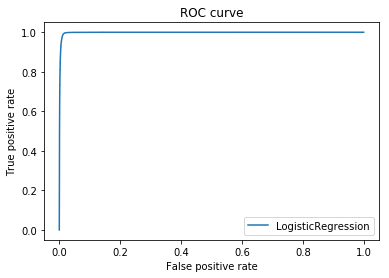

Area Under the Curve (AUC) from prediction score is 0.998210
G score is 0.986635
Specificity is 0.975283
Mean accuracy score is 0.992387
Confusion Marix
[[ 50229   1273]
 [   289 153385]]


In [42]:
# Split
x_train, x_test, y_train, y_test = log_reg.split(x,y,rand=None)
# Normalize
not_bi = log_reg.not_bi(x)
scaler = StandardScaler()
scaler.fit(x_train[not_bi]) 

x_train_scaled=x_train
x_test_scaled=x_test

x_train_scaled[not_bi] = scaler.transform(x_train[not_bi])
x_test_scaled[not_bi]  = scaler.transform(x_test[not_bi])

# Fit model
model = log_reg.reg(x_train_scaled,y_train)
# Evaluate model
log_reg.ModelValuation(x_test_scaled,y_test,model)
y_predicted = log_reg.y_pred(x_test_scaled,threshold=0.5)
spec , G = log_reg.GetScores(y_test,y_predicted)
log_reg.confusion(y_test,y_predicted,'Default Confusion Matrix')

Run Multi-Class(Ridge)

In [70]:
x_train_multi, x_test_multi, y_train_multi, y_test_multi = Multi_log_reg.split(x_multi,y_multi,rand=None)
# Normalize
not_bi = Multi_log_reg.not_bi(x_multi)
scaler = StandardScaler()
scaler.fit(x_train_multi[not_bi]) 

x_train_scaled_multi=x_train_multi
x_test_scaled_multi=x_test_multi

x_train_scaled_multi[not_bi] = scaler.transform(x_train_multi[not_bi])
x_test_scaled_multi[not_bi]  = scaler.transform(x_test_multi[not_bi])

# Fit model
model_multi = Multi_log_reg.reg(x_train_scaled_multi,y_train_multi)
# Evaluate model
print("Mean accuracy score is %f" % model_multi.score(x_test_scaled_multi,y_test_multi,sample_weight=None))

C:\Users\Xianzhe Xu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # Remove the CWD from sys.path while we load stuff.
C:\Users\Xianzhe Xu\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Xianzhe Xu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataF

Mean accuracy score is 0.898970


C:\Users\Xianzhe Xu\AppData\Local\Continuum\anaconda3\lib\site-packages\sklearn\linear_model\sag.py:326: ConvergenceWarning: The max_iter was reached which means the coef_ did not converge
  "the coef_ did not converge", ConvergenceWarning)


Check the mean accuracy score for every class

In [73]:
y_predicted_multi = model_multi.predict(x_test_multi)
cnt_0=0
cnt_0_predicted=0
cnt_1=0
cnt_1_predicted=0
cnt_2=0
cnt_2_predicted=0
cnt_3=0
cnt_3_predicted=0
for x in range(len(y_predicted_multi)):
    if y_test_multi[x]==0:
        cnt_0+=1
    if y_test_multi[x]==0 and y_predicted_multi[x]==0:
        cnt_0_predicted+=1 
    if y_test_multi[x]==1:
        cnt_1+=1
    if y_test_multi[x]==1 and y_predicted_multi[x]==1:
        cnt_1_predicted+=1 
    if y_test_multi[x]==2:
        cnt_2+=1
    if y_test_multi[x]==2 and y_predicted_multi[x]==2:
        cnt_2_predicted+=1 
    if y_test_multi[x]==3:
        cnt_3+=1
    if y_test_multi[x]==3 and y_predicted_multi[x]==3:
        cnt_3_predicted+=1 
print("mean accuracy for fully paid", cnt_0_predicted/cnt_0)
print("mean accuracy for Grace Period", cnt_1_predicted/cnt_1)
print("mean accuracy for Late", cnt_2_predicted/cnt_2)
print("mean accuracy for Default", cnt_3_predicted/cnt_3)

mean accuracy for fully paid 0.9981941015980252
mean accuracy for Grace Period 0.5038397328881469
mean accuracy for Late 0.5545619673047366
mean accuracy for Default 0.6159818907603933


Run Binary Logistic Regression with Lasso

C:\Users\Xianzhe Xu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  # This is added back by InteractiveShellApp.init_path()
C:\Users\Xianzhe Xu\AppData\Local\Continuum\anaconda3\lib\site-packages\pandas\core\indexing.py:517: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s
C:\Users\Xianzhe Xu\AppData\Local\Continuum\anaconda3\lib\site-packages\ipykernel_launcher.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a D

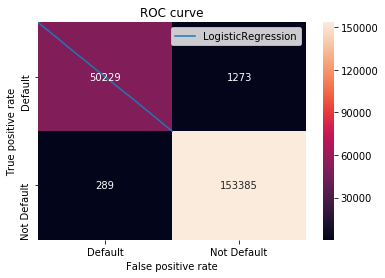

Area Under the Curve (AUC) from prediction score is 0.500720
G score is 0.912628
Specificity is 0.832965
Mean accuracy score is 0.958338
Confusion Marix
[[ 42557   8534]
 [    14 154071]]


In [80]:
# Split
x_train_L1, x_test_L1, y_train_L1, y_test_L1 = L1_log_reg.split(x,y,rand=None)
# Normalize
not_bi = log_reg.not_bi(x)
scaler = StandardScaler()
scaler.fit(x_train[not_bi]) 

x_train_scaled_L1=x_train_L1
x_test_scaled_L1=x_test_L1

x_train_scaled_L1[not_bi] = scaler.transform(x_train_L1[not_bi])
x_test_scaled_L1[not_bi]  = scaler.transform(x_test_L1[not_bi])

# Fit model
model_L1 = L1_log_reg.reg(x_train_scaled_L1,y_train_L1)
# Evaluate model
L1_log_reg.ModelValuation(x_test_scaled_L1,y_test,model_L1)
y_predicted_L1 = L1_log_reg.y_pred(x_test_scaled_L1,threshold=0.5)
spec , G = L1_log_reg.GetScores(y_test_L1,y_predicted_L1)
L1_log_reg.confusion(y_test,y_predicted,'Default Confusion Matrix')